# Simple MLP demo for TIMIT using Keras

This notebook describes how to reproduce the results for the simple MLP architecture described in this paper:

[ftp://ftp.idsia.ch/pub/juergen/nn_2005.pdf](ftp://ftp.idsia.ch/pub/juergen/nn_2005.pdf)

And in Chapter 5 of this thesis:

http://www.cs.toronto.edu/~graves/phd.pdf

To begin with, if you have a multi-gpu system (like I do), you may want to choose which GPU you want to run this on (indexing from 0):

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

Here we import the stuff we use below:

In [2]:
import numpy as np

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam, SGD

from IPython.display import clear_output
from tqdm import *

import sys

sys.path.append('../python')

from data import Corpus, History

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN not available)


## Loading the data

Here we load the corpus stored in HDF5 files. It contains both normalized and unnormalized data and we're interested in the former:

In [3]:
train=Corpus('../data/TIMIT_train.hdf5',load_normalized=True)
dev=Corpus('../data/TIMIT_dev.hdf5',load_normalized=True)
test=Corpus('../data/TIMIT_test.hdf5',load_normalized=True)

The data can be loaded all at once into separate Numpy arrays:

In [4]:
tr_in,tr_out_dec=train.get()
dev_in,dev_out_dec=dev.get()
tst_in,tst_out_dec=test.get()

The loaded data is a list of utterances, where each utterance is a matrix (for inputs) or a vector (for outputs) of different sizes. That is why the whole corpus is not a matrix (which would require that each utterance is the same length):

In [5]:
print tr_in.shape
print tr_in[0].shape
print tr_out_dec.shape
print tr_out_dec[0].shape

(3696,)
(302, 39)
(3696,)
(302,)


The papers/thesis above use 26 features instead of the standrd 39, ie they only use first-order regression coefficients (deltas). We usually prepare a corpus for the full 39 features, so to be comparable, lets extract the 26 from that:

In [6]:
for u in range(tr_in.shape[0]):
    tr_in[u]=tr_in[u][:,:26]
for u in range(dev_in.shape[0]):    
    dev_in[u]=dev_in[u][:,:26]
for u in range(tst_in.shape[0]):
    tst_in[u]=tst_in[u][:,:26]

## Parameters

Here we'll define some standard sizes and parameters:

In [7]:
input_dim=tr_in[0].shape[1]
output_dim=61
hidden_num=250
epoch_num=1500

### 1-hot vectors

For most loss functions, the output for each utterance needs to be a matrix of size (output_dim,sample_num). That means we need to convert the output from a list of decisions to a list of 1-hot vectors. This is a requirement of Keras:

In [8]:
def dec2onehot(dec):
    ret=[]
    for u in dec:
        assert np.all(u<output_dim)
        num=u.shape[0]
        r=np.zeros((num,output_dim))
        r[range(0,num),u]=1
        ret.append(r)
    return np.array(ret)

tr_out=dec2onehot(tr_out_dec)
dev_out=dec2onehot(dev_out_dec)
tst_out=dec2onehot(tst_out_dec)

## Model definition

Here we define the model exactly as in the paper: one hidden layer with 250 units, sigmoid activation in the hidden and softmax in the output, cross-entropy loss. The only thing that differs is the optimizer. You can use SGD, but the values in the paper seem to be far too small. Adam works just as well and maybe even a bit faster. Feel free to experiment:

In [9]:
model = Sequential()

model.add(Dense(input_dim=input_dim,output_dim=hidden_num))
model.add(Activation('sigmoid'))
model.add(Dense(output_dim=output_dim))
model.add(Activation('softmax'))

optimizer= SGD(lr=3e-3,momentum=0.9,nesterov=False)
loss='categorical_crossentropy'
metrics=['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

## Training

Here we have a training loop. We don't use the "fit" method to accomodate the specific conditions in the paper: we register the loss/accuracy of dev and test at each time step, we do weight update after each utterance.

In [10]:
from random import shuffle

tr_hist=History('Train')
dev_hist=History('Dev')
tst_hist=History('Test')

tr_it=range(tr_in.shape[0])

for e in range(epoch_num):
    
    print 'Epoch #{}/{}'.format(e+1,epoch_num)
    sys.stdout.flush()
    
    shuffle(tr_it)
    for u in tqdm(tr_it):
        l,a=model.train_on_batch(tr_in[u],tr_out[u])
        tr_hist.r.addLA(l,a,tr_out[u].shape[0])
    clear_output()    
    tr_hist.log()
    
    for u in range(dev_in.shape[0]):
        l,a=model.test_on_batch(dev_in[u],dev_out[u])
        dev_hist.r.addLA(l,a,dev_out[u].shape[0])
    dev_hist.log()
    
    
    for u in range(tst_in.shape[0]):
        l,a=model.test_on_batch(tst_in[u],tst_out[u])
        tst_hist.r.addLA(l,a,tst_out[u].shape[0])
    tst_hist.log()            
    
print 'Done!'
    

Train loss: 1.50441241264
Train PER: 46.840970%
Dev loss: 1.56283533573
Dev PER: 48.064693%
Test loss: 1.59579706192
Test PER: 48.617897%
Done!


## Results

Here we can plot the loss and PER (phoneme error rate) while training:

(45, 55)

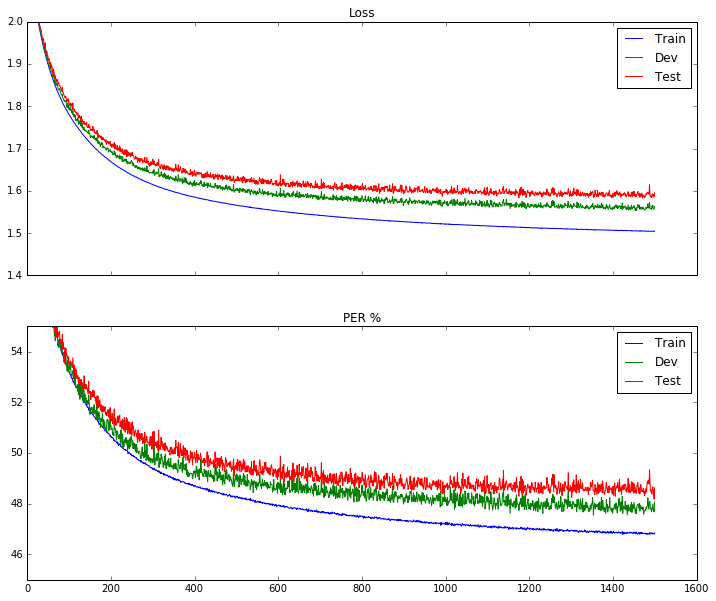

In [16]:
import matplotlib.pyplot as P
%matplotlib inline

fig,ax=P.subplots(2,sharex=True,figsize=(12,10))

ax[0].set_title('Loss')
ax[0].plot(tr_hist.loss,label='Train')
ax[0].plot(dev_hist.loss,label='Dev')
ax[0].plot(tst_hist.loss,label='Test')
ax[0].legend()
ax[0].set_ylim((1.4,2.0))

ax[1].set_title('PER %')
ax[1].plot(100*(1-np.array(tr_hist.acc)),label='Train')
ax[1].plot(100*(1-np.array(dev_hist.acc)),label='Dev')
ax[1].plot(100*(1-np.array(tst_hist.acc)),label='Test')
ax[1].legend()
ax[1].set_ylim((45,55))

The final results are presented below. Please note that Keras usually calculates accuracy, while the papers generally prefer error rates. We generally shouldn't give the result of the minimum PER for the test set, but we can use the dev set, find it's minimum and provide the value of the test at that time. You can see that the correct PER is not too far from the minimum test PER anyway:

In [12]:
print 'Min train PER: {:%}'.format(1-np.max(tr_hist.acc))
print 'Min test PER: {:%}'.format(1-np.max(tst_hist.acc))
print 'Min dev PER epoch: #{}'.format((np.argmax(dev_hist.acc)+1))
print 'Test PER on min dev: {:%}'.format(1-tst_hist.acc[np.argmax(dev_hist.acc)])

Min train PER: 46.795274%
Min test PER: 48.175901%
Min dev PER epoch: #1354
Test PER on min dev: 48.505672%


The paper gives a value of 48.6% error rate for this architecture and claims it took 835 epochs to reach the value using SGD. Here we can see that ADAM got it a bit faster than that:

In [13]:
wer=0.486999999999
print 'Epoch where PER reached {:%}: #{}'.format(wer,np.where((1-np.array(tst_hist.acc))<=wer)[0][0])

Epoch where PER reached 48.700000%: #732
